In [1]:
!python --version
#!pip install -r ./requirements.txt

Python 3.7.6


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from random import Random
import torch

In [4]:
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData

In [5]:
data = Cryptocurrencies(coin_search = 'USDC', extended_output=False).find_crypto_pairs()
data

Connected to the CoinBase Pro API.
Found 14 instances containing the term USDC.
Extended Output is False, returning reduced dataset.


,id,display_name,fx_stablecoin,max_slippage_percentage,status
19,GNT-USDC,GNT/USDC,False,0.03000000,delisted
22,USDC-EUR,USDC/EUR,True,0.01000000,delisted
131,DAI-USDC,DAI/USDC,True,0.01000000,delisted
184,CVC-USDC,CVC/USDC,False,0.03000000,delisted
188,DNT-USDC,DNT/USDC,False,0.03000000,delisted
209,BTC-USDC,BTC/USDC,False,0.03000000,delisted
210,MANA-USDC,MANA/USDC,False,0.03000000,delisted
213,ZEC-USDC,ZEC/USDC,False,0.03000000,delisted
229,USDC-GBP,USDC/GBP,True,0.01000000,delisted
238,BAT-USDC,BAT/USDC,False,0.03000000,delisted


In [6]:
period = 60*60*24 #seconds
asset_ls = ['BTC-USD','ETH-USD']
daily_history_df = pd.DataFrame()

for asset in asset_ls:
    daily = HistoricalData(asset, period,'2015-01-01-00-00').retrieve_data()
    daily['ticker'] = asset
    daily_history_df = pd.concat([daily_history_df,daily])

daily_history_df

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2015-01-01T00:00:00
Provisional End: 2015-10-28T00:00:00
Data for chunk 1 of 10 extracted
Provisional Start: 2015-10-28T00:00:00
Provisional End: 2016-08-23T00:00:00
Data for chunk 2 of 10 extracted
Provisional Start: 2016-08-23T00:00:00
Provisional End: 2017-06-19T00:00:00
Data for chunk 3 of 10 extracted
Provisional Start: 2017-06-19T00:00:00
Provisional End: 2018-04-15T00:00:00
Data for chunk 4 of 10 extracted
Provisional Start: 2018-04-15T00:00:00
Provisional End: 2019-02-09T00:00:00
Data for chunk 5 of 10 extracted
Provisional Start: 2019-02-09T00:00:00
Provisional End: 2019-12-06T00:00:00
Data for chunk 6 of 10 extracted
Provisional Start: 2019-12-06T00:00:00
Provisional End: 2020-10-01T00:00:00
Data for chunk 7 of 10 ext

,low,high,open,close,volume,ticker
time,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,BTC-USD
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,BTC-USD
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,BTC-USD
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,BTC-USD
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,BTC-USD
...,...,...,...,...,...,...
2022-07-26,1356.30,1454.56,1440.63,1449.63,283778.376876,ETH-USD
2022-07-27,1420.66,1645.46,1449.60,1636.40,388150.083533,ETH-USD
2022-07-28,1592.36,1792.55,1636.53,1725.19,446776.878715,ETH-USD


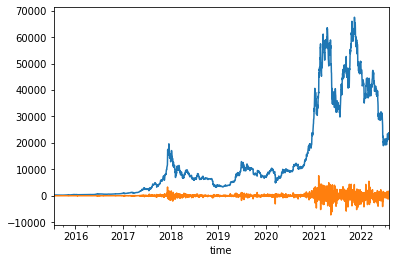

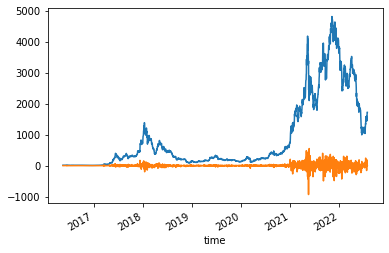

In [7]:
for asset in asset_ls:
    daily_df = daily_history_df[daily_history_df['ticker'] == asset].copy()
    daily_df['returns'] = daily_df['close'] -daily_df['open']
    daily_df['open'].plot()
    daily_df['returns'].plot()
    plt.show()

In [8]:
initial_allocation_ratio = np.array([[.6],[.2],[.1]])

portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
portfolio_df

,BTC,ETH,USD
time,,,
2016-05-18,0.6,0.2,0.1
2016-05-19,0.6,0.2,0.1
2016-05-20,0.6,0.2,0.1
2016-05-23,0.6,0.2,0.1
2016-05-24,0.6,0.2,0.1
...,...,...,...
2022-07-26,0.6,0.2,0.1
2022-07-27,0.6,0.2,0.1
2022-07-28,0.6,0.2,0.1


In [9]:
def get_daily_return(ticker, time, df=daily_history_df):
    if ticker == 'USD':
        return 1.0
    else:
        df = df.loc[time]
        asset_df = df[df['ticker'].apply(lambda x: ticker in x)]
        return (asset_df['close']/asset_df['open']).values[0]

In [10]:
def calc_asset_daily_returns(row):
    asset_ls = row.index
    time = row.name
    daily_returns_ls = np.array([get_daily_return(asset, time) for asset in asset_ls])
    return daily_returns_ls

In [11]:
def get_random_ratio():
    r_ar = np.random.random((len(asset_ls)+1,1))
    random_portfolio_ratio = r_ar / sum(r_ar)
    if random_portfolio_ratio[-1] > .5: #limit USD ratio to less than half
        return get_random_ratio()
    else:
        return (random_portfolio_ratio * 100).astype(int)/100

In [12]:
asset_daily_returns_df = portfolio_df.apply(lambda x: pd.Series(calc_asset_daily_returns(x),index=portfolio_df.columns), axis=1)
asset_daily_returns_df

,BTC,ETH,USD
time,,,
2016-05-18,1.003016,1.054400,1.0
2016-05-19,0.962288,1.130501,1.0
2016-05-20,1.017675,0.956140,1.0
2016-05-23,1.007278,0.981962,1.0
2016-05-24,1.003209,0.933480,1.0
...,...,...,...
2022-07-26,0.997631,1.006247,1.0
2022-07-27,1.080073,1.128863,1.0
2022-07-28,1.038804,1.054176,1.0


In [13]:
initial_allocation_total_value=1000.00
initial_allocation_ratio=np.array([[.6],[.2],[.1]])
asset_daily_returns_df=asset_daily_returns_df

initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)


return_df = (asset_daily_returns_df).shift(1)
accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

shape = accumulator_df.shape[0]
cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
    np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)
accumulator_df

,BTC,ETH,USD
time,,,
2016-05-18,600,200,100
2016-05-19,601.81,210.88,100
2016-05-20,579.114,238.4,100
2016-05-23,589.35,227.944,100
2016-05-24,593.639,223.832,100
...,...,...,...
2022-07-26,27775.3,24851.9,100
2022-07-27,27709.5,25007.2,100
2022-07-28,29928.2,28229.7,100


In [14]:
def get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=np.array([[.6],[.2],[.2]]), asset_daily_returns_df=asset_daily_returns_df):

    initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
    portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
    
    return_df = (asset_daily_returns_df).shift(1)
    accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
    accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

    shape = accumulator_df.shape[0]
    cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
        np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

    accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)

    return accumulator_df

get_accumulated_return(initial_allocation_ratio=np.array([[.6],[.2],[.1]]))

,BTC,ETH,USD
time,,,
2016-05-18,600,200,100
2016-05-19,601.81,210.88,100
2016-05-20,579.114,238.4,100
2016-05-23,589.35,227.944,100
2016-05-24,593.639,223.832,100
...,...,...,...
2022-07-26,27775.3,24851.9,100
2022-07-27,27709.5,25007.2,100
2022-07-28,29928.2,28229.7,100


[[ 90.]
 [360.]
 [500.]]


,[0.09 0.36 0.5 ]
time,
2016-05-18,950.000000
2016-05-19,969.855472
2016-05-20,1015.987170
2016-05-23,998.701483
2016-05-24,991.944072
...,...
2022-07-26,49399.750023
2022-07-27,49669.341619
2022-07-28,55802.664993


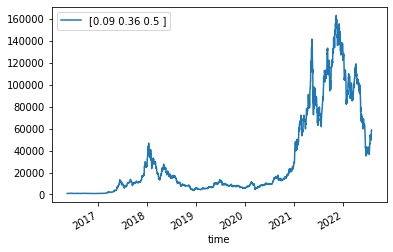

[0.09 0.36 0.5 ]  <lambda>    0.518053
dtype: float64

In [15]:
ratio_ls = [#'BTC','ETH','ADA','USD'
             [[0.09 ],[0.36],[0.5]]
            ]

marker_ls = ['-','-.','x','v']
portfolios = pd.DataFrame()

for i,ratio in enumerate(ratio_ls):
    initial_allocation_ratio = np.array(ratio)
    initial_allocation_total_value = 1000.00
    initial_allocation = initial_allocation_ratio  * initial_allocation_total_value
    print(initial_allocation)
    current_portfolio = get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=initial_allocation_ratio)\
        .sum(axis=1).to_frame().rename(columns={0:str(initial_allocation_ratio.flatten())})
    display(current_portfolio)
    portfolios = pd.concat([portfolios , current_portfolio], axis=1)
portfolios.plot()
plt.show()
agg_period = 90
sharp_calc_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)])
sharp_df = sharp_calc_df .mean()
display(sharp_df)

[0.09 0.36 0.5 ]  <lambda>    0.518053
dtype: float64


,[0.09 0.36 0.5 ]
count,2263.000000
mean,30422.067502
std,39166.320910
min,858.134248
25%,6377.184840
50%,10695.334592
75%,39279.764757
max,162795.143518


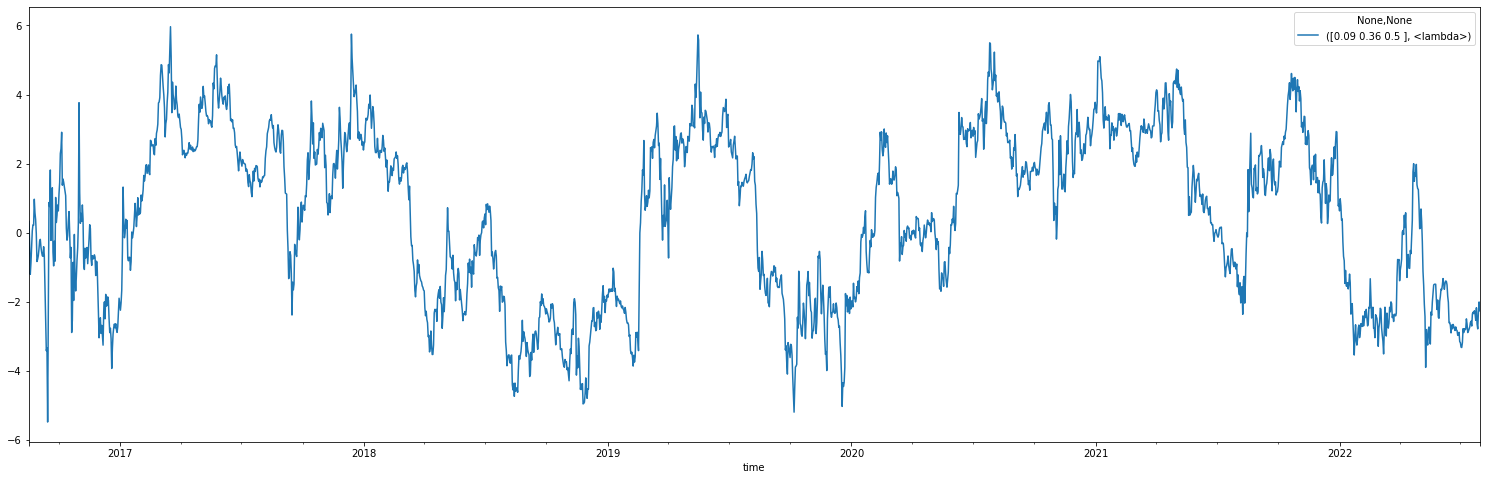

In [16]:
agg_period = 90
sharp_calc_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)])
sharp_calc_df.dropna().plot(figsize=(26,8))

sharp_df = portfolios.rolling(agg_period).agg([lambda x: (x[-1]-x[0])/np.std(x)]).mean()
print(sharp_df[sharp_df.max()==sharp_df])
portfolios.describe()

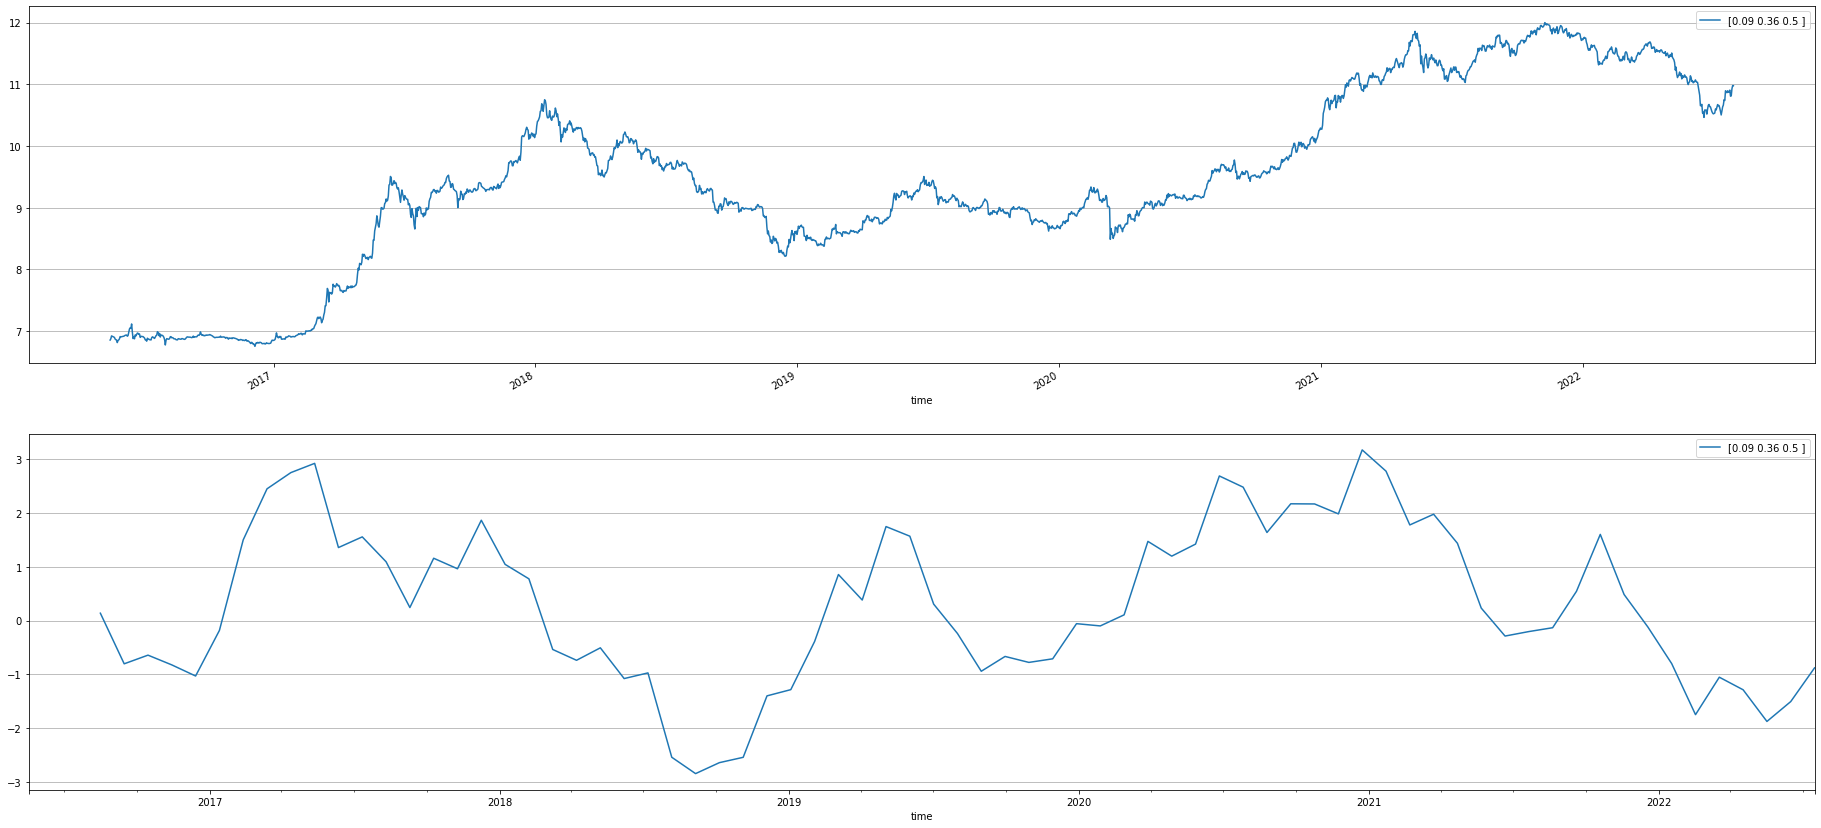

In [17]:
fig, ax = plt.subplots(2,1,figsize=(32,16))
portfolios.apply(lambda x: np.log(x)).plot(ax=ax[0])
portfolios.resample('30d').pipe(lambda df: (df.last() - df.first())/df.std()).rolling(4).mean().plot(ax=ax[1])

ax[0].yaxis.grid()
ax[1].yaxis.grid()

In [18]:
def generate_eval_portfolio(initial_allocation_total_value=1000):
    ratio_ls = [#'BTC','ETH','USD'
                get_random_ratio(),
                ]
   
    for i,ratio in enumerate(ratio_ls):
        initial_allocation_ratio = np.array(ratio)
        initial_allocation = initial_allocation_ratio * initial_allocation_total_value
        
        current_portfolio = get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=initial_allocation_ratio)\
            .sum(axis=1).to_frame().rename(columns={0:str(initial_allocation_ratio.flatten())})
    
    return  current_portfolio.resample('30d').pipe(lambda df: (df.last() - df.first())/df.std()).mean(axis=0)

In [19]:
%%time
for _ in range(1000):
    get_accumulated_return()

CPU times: user 2.68 s, sys: 443 µs, total: 2.68 s
Wall time: 2.68 s


### Static portfolio allocation sampling by brute force grid search

In [20]:
%%time
from tqdm import tqdm
from IPython.display import clear_output

best = -np.inf
for i in tqdm(range(int(1e2))):
    best_out_of_4 = generate_eval_portfolio()
    #print(best_out_of_4.values[0] )
    if best_out_of_4.values[0] > best:
        best = best_out_of_4.values[0]
        optimal_ratio = best_out_of_4.index[0]
        clear_output(wait=True)
        print('optimal_ratio', optimal_ratio)
        print('best sharp', best)
        plt.show()

 64%|██████▍   | 64/100 [00:00<00:00, 100.72it/s]

optimal_ratio [0.65 0.21 0.13]
best sharp 0.5304514600730081


100%|██████████| 100/100 [00:00<00:00, 103.41it/s]

CPU times: user 971 ms, sys: 4.35 ms, total: 975 ms
Wall time: 969 ms


### Dynanmic portfolio allocation thru AI portfolio manager

#### Portfolio rebalancing can be simulated on 7 period with the goal of beating the best static allocation. Timeseries crossvalidation will be implemented to validate/simulate the lack of future performance informatio(eg. ETH outperformed all other assets).

#### Model will output portfolio ratios for each of the 3 assets. The loss function will be best what-if ratio on last 7 day period.

#### First method will be a simple approach with previous portfolio ratio and current portfolio values in \$ info as features to a portfolio mangement model. Output will be the asset ratio of the portfolio. Optimization of the model weight will be based on Genetic Algo based on regularized loss function. Regularization will be based on minimizing allocation changes and even distribution of ratios on assets.

## Use longer term return as fitness function in Genetic Algorithm to opitimize Pytorch NN

In [21]:
def get_accumulated_return(initial_allocation_total_value=1000.00, initial_allocation_ratio=np.array([[.6],[.3],[.1]]), asset_daily_returns_df=asset_daily_returns_df):
    ratio_total = round(initial_allocation_ratio.sum(),6)
    assert ratio_total == 1, f"ratio total is {ratio_total} and doesnt add up to 1"
    initial_allocation = initial_allocation_ratio * initial_allocation_total_value 
    portfolio_df = pd.DataFrame(np.repeat(initial_allocation_ratio, daily_df.shape[0], axis=1).T,columns=['BTC','ETH','USD'],index=daily_df.index)
    
    return_df = (asset_daily_returns_df).shift(1)
    accumulator_df = pd.DataFrame(columns=asset_daily_returns_df.columns,index=asset_daily_returns_df.index)
    accumulator_df.iloc[0] = pd.Series(initial_allocation.flatten(),index=asset_daily_returns_df.columns) # initialize portfolio value of first index

    shape = accumulator_df.shape[0]
    cummulated_returns = (np.cumprod(return_df.shift(-1).values, axis=0)-1)*np.tile(initial_allocation,[shape,1]).reshape(shape, accumulator_df.columns.shape[0]) +\
        np.tile(initial_allocation,[shape,1]).reshape(shape,accumulator_df.columns.shape[0])

    accumulator_df.iloc[1:] = pd.DataFrame(cummulated_returns, index=accumulator_df.index).shift(1)
    return accumulator_df

In [22]:
porfolio_details = get_accumulated_return()
portfolio_value_df = porfolio_details.copy()
portfolio_value_df['total_value'] = porfolio_details.sum(axis=1)

#### reallocating asset back to the ratio

In [23]:
gains_ls = []
adjustment_period = 7 ###ratio redistribution period
porfolio_details = pd.DataFrame()
for i in range(0,asset_daily_returns_df.shape[0]-adjustment_period, adjustment_period):
    current_portfolio_total = initial_allocation_total_value=1000.00 if i==0 else periodic_returns.tail(1).sum(axis=1).values[0]
    periodic_returns = get_accumulated_return(current_portfolio_total, initial_allocation_ratio=np.array([[.6],[.3],[.1]]),
                                        asset_daily_returns_df= asset_daily_returns_df.iloc[i:i+adjustment_period])
    gains_ls+=[(periodic_returns.tail(1).sum(axis=1).values[0],
                asset_daily_returns_df.iloc[i+adjustment_period].name)]
    porfolio_details=porfolio_details.append(periodic_returns.iloc[-1])
    
portfolio_value_df = porfolio_details.copy()
portfolio_value_df['total_value'] = porfolio_details.sum(axis=1)
portfolio_value_df

,BTC,ETH,USD,total_value
2016-05-26,601.553587,304.011902,100.000000,1005.565488
2016-06-02,709.317128,328.432426,100.556549,1138.306104
2016-06-09,740.514452,356.342105,113.830610,1210.687167
2016-06-16,879.479005,447.264553,121.068717,1447.812274
2016-06-23,678.840992,296.523794,144.781227,1120.146013
...,...,...,...,...
2022-06-30,66112.783584,33358.354239,11566.342241,111037.480065
2022-07-07,68469.570308,36885.808579,11103.748006,116459.126894
2022-07-14,65358.833908,31450.150804,11645.912689,108454.897402
2022-07-21,73443.037889,41543.775466,10845.489740,125832.303095


In [24]:
#### static allocation
display(get_accumulated_return().iloc[:i+adjustment_period])
get_accumulated_return().iloc[i+adjustment_period].sum(axis=0)

,BTC,ETH,USD
time,,,
2016-05-18,600,300,100
2016-05-19,601.81,316.32,100
2016-05-20,579.114,357.6,100
2016-05-23,589.35,341.916,100
2016-05-24,593.639,335.748,100
...,...,...,...
2022-07-24,29258.1,40092.9,100
2022-07-25,29430.2,41349.7,100
2022-07-26,27775.3,37277.9,100


75828.12234551097

#### A adjustment_period day redistribution strategy Netted over 2x more than static allocation (aka buy and hold)

In [25]:
def generate_row_data(index=0, period=adjustment_period, portfolio=[600,300,100], allocation_ratio=np.array([[.6],[.3],[.1]])):
    output_portfolio = get_accumulated_return(initial_allocation_total_value=sum(portfolio), initial_allocation_ratio=allocation_ratio, asset_daily_returns_df=asset_daily_returns_df.iloc[index:index+period])
    return output_portfolio.iloc[-1].values.astype(float)

generate_row_data(index=0, period=adjustment_period, portfolio=[800,300,100], allocation_ratio=np.array([[.6],[.3],[.1]]))

array([721.86430406, 364.81428183, 120.        ])

In [26]:
# Create the PyTorch base model.
input_layer = torch.nn.Linear(3, 8)
relu_layer = torch.nn.ReLU()
hidden_layer1 = torch.nn.Linear(8, 16)
hidden_layer2 = torch.nn.Linear(16, 8)
output_layer = torch.nn.Linear(8, 3)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            hidden_layer1,
                            relu_layer,
                            hidden_layer2,
                            relu_layer,
                            output_layer)
model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=3, bias=True)
)

In [27]:
[layer.shape for layer in model.parameters()]

[torch.Size([8, 3]),
 torch.Size([8]),
 torch.Size([16, 8]),
 torch.Size([16]),
 torch.Size([8, 16]),
 torch.Size([8]),
 torch.Size([3, 8]),
 torch.Size([3])]

In [28]:
from torch import nn

# LSTM with no batch reset on hidden and cell state
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Initializing hidden state for first input with zeros
        self.h0 = torch.zeros(self.layer_dim, 1, self.hidden_dim).requires_grad_()
        # Initializing cell state for first input with zeros
        self.c0 = torch.zeros(self.layer_dim, 1, self.hidden_dim).requires_grad_()
        
    def forward(self, x):
        #print(x.shape)
        x = x.unsqueeze(0).unsqueeze(0)
        #print(x.shape)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        self.h0 = hn # Batches are in timely order. Hidden states can be passed thru batches.
        self.c0 = cn
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        out = out.squeeze(0)
        return out
    
lstm_layer = LSTMModel(3,32,4,3,.2)
model = lstm_layer

In [29]:
[layer.shape for layer in lstm_layer.parameters()]

[torch.Size([128, 3]),
 torch.Size([128, 32]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 32]),
 torch.Size([128, 32]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 32]),
 torch.Size([128, 32]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 32]),
 torch.Size([128, 32]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([3, 32]),
 torch.Size([3])]

In [30]:
import pygad
from pygad import torchga

torch_ga = torchga.TorchGA(model=model,
                                num_solutions=120)

In [31]:
# Data inputs
data_inputs = generate_row_data(index=0, period=adjustment_period, portfolio=[800,300,100], allocation_ratio=np.array([[.5],[.4],[.1]]))
data_inputs, model(torch.from_numpy(data_inputs).float()), torch.nn.functional.normalize(torch.abs(model(torch.from_numpy(data_inputs).float())), p=1,dim=0)

(array([601.55358672, 486.41904244, 120.        ]),
 tensor([-0.0516,  0.0178, -0.0287], grad_fn=<SqueezeBackward1>),
 tensor([0.4953, 0.1853, 0.3194], grad_fn=<DivBackward0>))

In [32]:
np.cumprod(np.array([0.4086, 0.4434, 0.4480]),axis=0)[-1]

0.08116561152000001

In [33]:
def fitness_func(solution, sol_idx):
    global torch_ga, model,  sol_pred, sol_portfolio
    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)
    #print(model_weights_dict['lstm.weight_ih_l0'])
    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)
    #print(f'{sol_idx} prev_portfolio',prev_portfolio)
    data_inputs = generate_row_data(index=epoch*period, period=period, portfolio=prev_portfolio, allocation_ratio=prev_pred)
    sol_portfolio[sol_idx] = data_inputs
    
    pred = torch.nn.functional.normalize(torch.abs(model(torch.from_numpy(data_inputs).float())),p=1,dim=0).reshape(3,1).detach().numpy()
    #print(pred)
    sol_pred[sol_idx] = pred
    
    updated_pred = generate_row_data(index=epoch*period, period=period, portfolio=prev_portfolio, allocation_ratio=pred) 
    #print(updated_pred)
    
    reg_fact1 = 1e-1
    reg_fact2 = 1e-3
    #fitness function is regularized for portfolio ratio changes and even distribution
    solution_fitness = (updated_pred).sum() - reg_fact1*(updated_pred).sum()*(np.abs(prev_pred - pred)).sum() - reg_fact2/np.cumprod(pred,axis=0)[-1]*(updated_pred).sum()
    #solution_fitness = (updated_pred).sum()*(1-reg_fact1*(np.abs(prev_pred - pred)).sum())*(1-reg_fact2/np.cumprod(pred,axis=0)[-1]) 
    return solution_fitness[0]

In [34]:
def callback_generation(ga_instance):
    global prev_pred, prev_portfolio, epoch, optimized_portfolio, portfolio_values
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print(f"Date {portfolio_value_df.index[epoch]}")
    sol_idx = ga_instance.best_solution()[2]
    prev_pred = sol_pred[sol_idx]
    print(sol_pred[sol_idx].flatten())
    prev_portfolio = sol_portfolio[sol_idx]
    
    current_portfolio = pd.DataFrame([sol_pred[sol_idx].flatten()], columns=['BTC','ETH','USD'], index=[portfolio_value_df.index[epoch]])
    optimized_portfolio = pd.concat([ optimized_portfolio, current_portfolio])
    
    current_portfolio_values = pd.DataFrame([sol_portfolio[sol_idx].flatten()], columns=['BTC','ETH','USD'], index=[portfolio_value_df.index[epoch]])
    portfolio_values = pd.concat([ portfolio_values, current_portfolio_values])
    
    epoch += 1

In [54]:
np.random.seed(0) #fix weights update
torch.manual_seed(0) #fix init weights

model = LSTMModel(3,32,4,3,.2)
torch_ga = torchga.TorchGA(model=model, num_solutions=40)#num_solutions=120)

num_generations = np.floor(daily.shape[0]/adjustment_period).astype(int) #Each generation is adjustment_period day period weight update based on how well to optimize this current period
num_parents_mating = 10
initial_population = torch_ga.population_weights

print(initial_population[0])
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       crossover_type =  "uniform",
                       mutation_type = None,
                       on_generation=callback_generation,)

optimized_portfolio = pd.DataFrame()
portfolio_values = pd.DataFrame()

prev_pred = np.array([[.6],[.3],[.1]])
prev_portfolio = np.array([600,300,100])

sol_pred = {}
sol_portfolio = {}

epoch = 0
period = adjustment_period

ga_instance.run()

print(prev_portfolio, prev_portfolio.sum())

[-0.0013235   0.09483072 -0.14549519 ... -0.0275025   0.10656282
 -0.13008113]
Generation = 1
Fitness    = 954.2748413085938
Date 2016-05-26 00:00:00
[0.588035   0.30689374 0.10507125]
Generation = 2
Fitness    = 1067.0260009765625
Date 2016-06-02 00:00:00
[0.60654336 0.22782649 0.16563016]
Generation = 3
Fitness    = 1133.5711669921875
Date 2016-06-09 00:00:00
[0.5618967  0.19834967 0.23975365]
Generation = 4
Fitness    = 1351.18798828125
Date 2016-06-16 00:00:00
[0.48697457 0.28927407 0.22375135]
Generation = 5
Fitness    = 1113.9688720703125
Date 2016-06-23 00:00:00
[0.34874147 0.20183896 0.4494196 ]
Generation = 6
Fitness    = 1055.3458251953125
Date 2016-06-30 00:00:00
[0.3378317  0.18937407 0.4727943 ]
Generation = 7
Fitness    = 1036.7667236328125
Date 2016-07-07 00:00:00
[0.3274743  0.19336706 0.4791587 ]
Generation = 8
Fitness    = 1057.31201171875
Date 2016-07-14 00:00:00
[0.3051632  0.24117161 0.4536652 ]
Generation = 9
Fitness    = 1093.1834716796875
Date 2016-07-21 00:00:0

[0.3819644  0.30688354 0.31115213]
Generation = 78
Fitness    = 7754.4296875
Date 2017-11-16 00:00:00
[0.36379233 0.30330035 0.3329074 ]
Generation = 79
Fitness    = 8249.357421875
Date 2017-11-23 00:00:00
[0.35948637 0.30554146 0.33497214]
Generation = 80
Fitness    = 9149.0205078125
Date 2017-11-30 00:00:00
[0.36366367 0.3029421  0.3333942 ]
Generation = 81
Fitness    = 10754.78515625
Date 2017-12-07 00:00:00
[0.5435653  0.24191675 0.21451798]
Generation = 82
Fitness    = 12186.4873046875
Date 2017-12-14 00:00:00
[0.37870136 0.3947986  0.2265001 ]
Generation = 83
Fitness    = 12089.6328125
Date 2017-12-21 00:00:00
[0.3835738 0.3120607 0.3043655]
Generation = 84
Fitness    = 12106.5419921875
Date 2017-12-28 00:00:00
[0.3730229  0.28767365 0.33930346]
Generation = 85
Fitness    = 13478.7158203125
Date 2018-01-04 00:00:00
[0.34660578 0.46684733 0.18654694]
Generation = 86
Fitness    = 15132.8984375
Date 2018-01-11 00:00:00
[0.40976587 0.47823513 0.11199903]
Generation = 87
Fitness    = 

[0.41830215 0.22720598 0.3544919 ]
Generation = 156
Fitness    = 12544.25
Date 2019-05-16 00:00:00
[0.4033922  0.3439554  0.25265244]
Generation = 157
Fitness    = 11859.916015625
Date 2019-05-23 00:00:00
[0.38009834 0.32298654 0.29691514]
Generation = 158
Fitness    = 12643.39453125
Date 2019-05-30 00:00:00
[0.3841738  0.32457837 0.29124776]
Generation = 159
Fitness    = 12290.2919921875
Date 2019-06-06 00:00:00
[0.36533922 0.3298893  0.30477148]
Generation = 160
Fitness    = 12659.97265625
Date 2019-06-13 00:00:00
[0.3661122  0.31131315 0.32257468]
Generation = 161
Fitness    = 13503.12890625
Date 2019-06-20 00:00:00
[0.3596238 0.294189  0.3461872]
Generation = 162
Fitness    = 16233.8974609375
Date 2019-06-27 00:00:00
[0.3609988  0.38281813 0.256183  ]
Generation = 163
Fitness    = 16133.1708984375
Date 2019-07-04 00:00:00
[0.37219757 0.34629473 0.28150776]
Generation = 164
Fitness    = 17153.828125
Date 2019-07-11 00:00:00
[0.35016966 0.34469357 0.30513677]
Generation = 165
Fitness

[0.4145385  0.27314523 0.31231624]
Generation = 234
Fitness    = 26011.126953125
Date 2020-11-12 00:00:00
[0.41359326 0.2834055  0.30300117]
Generation = 235
Fitness    = 27265.8046875
Date 2020-11-19 00:00:00
[0.41113085 0.28231916 0.30654997]
Generation = 236
Fitness    = 29429.37109375
Date 2020-11-26 00:00:00
[0.40566033 0.30381167 0.290528  ]
Generation = 237
Fitness    = 32117.548828125
Date 2020-12-03 00:00:00
[0.41182736 0.2997398  0.2884328 ]
Generation = 238
Fitness    = 30886.71484375
Date 2020-12-10 00:00:00
[0.41901872 0.28018716 0.30079412]
Generation = 239
Fitness    = 34280.6015625
Date 2020-12-17 00:00:00
[0.4380369  0.27666894 0.28529418]
Generation = 240
Fitness    = 33600.76171875
Date 2020-12-24 00:00:00
[0.43512273 0.22093453 0.34394273]
Generation = 241
Fitness    = 38459.40234375
Date 2020-12-31 00:00:00
[0.43719113 0.25253484 0.310274  ]
Generation = 242
Fitness    = 51178.2109375
Date 2021-01-07 00:00:00
[0.42128673 0.37329814 0.2054151 ]
Generation = 243
Fitn

Fitness    = 80308.15625
Date 2022-05-19 00:00:00
[0.3350897  0.3113818  0.35352847]
Generation = 314
Fitness    = 79160.0234375
Date 2022-05-26 00:00:00
[0.31653318 0.3137531  0.36971375]
Generation = 315
Fitness    = 79905.78125
Date 2022-06-02 00:00:00
[0.335565   0.33589587 0.32853907]
Generation = 316
Fitness    = 79282.734375
Date 2022-06-09 00:00:00
[0.3286048  0.34338093 0.3280143 ]
Generation = 317
Fitness    = 65698.3515625
Date 2022-06-16 00:00:00
[0.27148962 0.19047599 0.5380344 ]
Generation = 318
Fitness    = 62772.24609375
Date 2022-06-23 00:00:00
[0.32209143 0.19375136 0.48415726]
Generation = 319
Fitness    = 61967.890625
Date 2022-06-30 00:00:00
[0.30961615 0.1918917  0.49849215]
Generation = 320
Fitness    = 63771.09375
Date 2022-07-07 00:00:00
[0.2874251  0.21524723 0.4973277 ]
Generation = 321
Fitness    = 60986.49609375
Date 2022-07-14 00:00:00
[0.35951635 0.1670013  0.4734823 ]
Generation = 322
Fitness    = 67814.1328125
Date 2022-07-21 00:00:00
[0.3618154  0.3419

### Dynamic portfolio management can beat static allocation did not beat adjustment_period day reallocation based on static ratio and 7 rellalocation on fixed ratio

In [55]:
pd.options.plotting.backend = "plotly"

In [56]:
optimized_portfolio.plot()

In [ ]:
portfolio_values.plot()

In [ ]:
portfolio_values.sum(axis=1).to_frame().plot()